## American Monte Carlo Demo

Pupose: American Monte Carlo (a.k.a. Least Squares Monte Carlo or Longstaff-Schwartz Monte Carlo) demonstration on equity options. The following option types are supported:

| Exercise Style | Option Type | Barrier Type | Supported? |
|----------------|-------------|--------------|------------|
| European       | Call / Put  | Down-and-In  | Yes        |
| European       | Call / Put  | Up-and-In    | Yes        |
| American       | Call / Put  | Down-and-In  | Yes        |
| American       | Call / Put  | Up-and-In    | Yes        |
| Bermudan       | Call / Put  | Down-and-In  | No         |
| Bermudan       | Call / Put  | Up-and-In    | No         |
| European       | Call / Put  | None         | Yes        |
| American       | Call / Put  | None         | Yes        |
| Bermudan       | Call / Put  | None         | Yes        |
| Any            | Call / Put  | Knock-Out    | No         |

Note that Down-and-In barriers are supported for `barrier_level` $< S_0$. Barrier levels above initial stock price $S_0$ will be converted to Up-and-Out barriers.

Option prices calculated with American Monte Carlo algorithm can be compared to QuantLib pricing engine.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import QuantLib as ql
import matplotlib.cm as cm
import matplotlib.colors as mcolors

In [5]:
# Set up the QuantLib engine based on exercise type
def setup_exercise_and_engine(S0, r, T, sigma, n_steps, exercise_type="European", n_exercise_dates=1, barrier_level=None):
    calendar = ql.NullCalendar()
    day_count = ql.Actual365Fixed()
    today = ql.Date().todaysDate()
    ql.Settings.instance().evaluationDate = today

    spot_handle = ql.QuoteHandle(ql.SimpleQuote(S0))
    flat_ts = ql.YieldTermStructureHandle(ql.FlatForward(today, r, day_count))
    vol_ts = ql.BlackVolTermStructureHandle(ql.BlackConstantVol(today, calendar, sigma, day_count))
    process = ql.BlackScholesProcess(spot_handle, flat_ts, vol_ts)

    # Exercise and engine setup functions
    def european_exercise_and_engine():
        exercise = ql.EuropeanExercise(today + int(T * 365))
        engine = ql.AnalyticEuropeanEngine(process)
        return exercise, engine

    def bermudan_exercise_and_engine():
        exercise_dates = [today + int(t * 365 * T / n_steps)
                          for t in np.linspace(1, n_steps, n_exercise_dates, dtype=int)]
        exercise = ql.BermudanExercise(exercise_dates)
        engine = ql.BinomialVanillaEngine(process, "crr", n_steps)
        return exercise, engine

    def american_exercise_and_engine():
        exercise = ql.AmericanExercise(today, today + int(T * 365))
        engine = ql.BinomialVanillaEngine(process, "crr", n_steps)
        return exercise, engine

    # Barrier option handling
    if barrier_level is not None:
        # Use the specified exercise type
        if exercise_type == "European":
            exercise = ql.EuropeanExercise(today + int(T * 365))
            engine = ql.AnalyticBarrierEngine(process)
        elif exercise_type == "American":
            exercise = ql.AmericanExercise(today, today + int(T * 365))
            engine = ql.BinomialBarrierEngine(process, "crr", n_steps)
        else:
            raise NotImplementedError("Barrier options with Bermudan exercise are not implemented.")
        return exercise, engine

    # Map exercise styles to their respective exercise and engine functions
    exercise_map = {
        "European": european_exercise_and_engine,
        "Bermudan": bermudan_exercise_and_engine,
        "American": american_exercise_and_engine
    }

    return exercise_map[exercise_type]()


# Generate QuantLib option for comparison
def get_quantlib_option(S0, K, r, T, sigma, n_steps, option_type="Call", exercise_type="European", n_exercise_dates=1, barrier_level=None):
    exercise, engine = setup_exercise_and_engine(S0, r, T, sigma, n_steps, exercise_type, n_exercise_dates, barrier_level)
    option_type = ql.Option.Put if option_type == "Put" else ql.Option.Call
    payoff = ql.PlainVanillaPayoff(option_type, K)
    if barrier_level is not None:
        barrier_type = ql.Barrier.DownIn if barrier_level < S0 else ql.Barrier.UpIn
        option = ql.BarrierOption(barrier_type, barrier_level, 0.0, payoff, exercise)
    else:
        option = ql.VanillaOption(payoff, exercise)
    option.setPricingEngine(engine)
    return option


# Generate Monte Carlo asset price paths using GBM
def generate_asset_paths(S0, r, sigma, T, n_time_steps, n_paths):
    dt = T / n_time_steps
    Z = np.random.normal(size=(n_paths, n_time_steps))
    growth_factor = (r - 0.5 * sigma ** 2) * dt
    diffusion_factor = sigma * np.sqrt(dt) * Z
    paths = np.exp(growth_factor + diffusion_factor).cumprod(axis=1) * S0
    paths[:, 0] = S0
    return paths


# Calculate intrinsic value
def intrinsic_value(S, K, option_type="Call"):
    return np.maximum(K - S, 0) if option_type == "Put" else np.maximum(S - K, 0)


# Define exercise dates based on option type
def get_exercise_dates(exercise_type, n_time_steps, n_exercise_dates):
    if exercise_type == "European":
        return [n_time_steps - 1]
    elif exercise_type == "Bermudan":
        return np.linspace(0, n_time_steps - 1, n_exercise_dates + 1, dtype=int)[1:]
    elif exercise_type == "American":
        return np.arange(1, n_time_steps)


# Update cashflows based on regression of continuation values
def update_cashflows(paths, t, K, r, dt, cashflows, exercise_times, option_values, continuation_values, option_type,
                     barrier_hit):
    in_the_money = intrinsic_value(paths[:, t], K, option_type) > 0
    valid_paths = barrier_hit & in_the_money
    X, Y = paths[valid_paths, t], cashflows[valid_paths] * np.exp(-r * dt * (exercise_times[valid_paths] - t))

    if len(X) > 0:
        continuation_estimated = regression_estimate(X, Y, basis_type, degree)
        exercise_value = intrinsic_value(X, K, option_type)
        apply_exercise(cashflows, exercise_times, np.where(valid_paths)[0], exercise_value, continuation_estimated, t)
        store_option_values(t, paths[:, t], cashflows, option_values, continuation_values, continuation_estimated)


# Generate basis polynomials based on the selected basis type
def get_basis_polynomials(X, basis_type, degree):
    basis_func_map = {"Power": lambda X, i: X ** i,
                      "Chebyshev": lambda X, i: np.polynomial.chebyshev.chebval(X, [0] * i + [1]),
                      "Legendre": lambda X, i: np.polynomial.legendre.legval(X, [0] * i + [1]),}

    if basis_type not in basis_func_map:
        raise ValueError(f"Unknown basis type '{basis_type}'. Use 'Power', 'Chebyshev', or 'Legendre'.")

    return np.column_stack([basis_func_map[basis_type](X, i) for i in range(degree + 1)])


# Regression estimate of continuation value using specified basis functions
def regression_estimate(X, Y, basis_type="Power", degree=3):
    A = get_basis_polynomials(X, basis_type, degree)
    coeffs = np.linalg.lstsq(A, Y, rcond=None)[0]
    return A @ coeffs


# Apply exercise if intrinsic value > continuation value
def apply_exercise(cashflows, exercise_times, in_the_money_idx, exercise_value, continuation_estimated, t):
    exercise = exercise_value > continuation_estimated
    selected_idx = in_the_money_idx[exercise]
    cashflows[selected_idx], exercise_times[selected_idx] = exercise_value[exercise], t


# Store option and continuation values (optionally) during LSMC backward iteration
def store_option_values(t, stock_prices, cashflows, option_values, continuation_values, continuation_estimated=None):
    option_values.append((t, stock_prices[:len(cashflows)], cashflows[:len(cashflows)]))
    if continuation_estimated is not None:
        continuation_values.append((t, stock_prices[:len(continuation_estimated)], continuation_estimated))
    else:
        continuation_values.append((t, stock_prices[:len(cashflows)], cashflows[:len(cashflows)]))


# Plot LSMC process with option and continuation values
def plot_lsmc_grid(option_values, continuation_values, paths, dt,
                   key_S_lines=None, plot_asset_paths=True, plot_values=False):
    fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharey=True)
    cmap = cm.viridis
    vmin, vmax = get_color_range(option_values, continuation_values)

    # Plot option and continuation values with auxiliary grid and asset paths
    plot_value_scatter(option_values, paths, dt, axes[0], "Option Values", vmin, vmax,
                       key_S_lines, plot_asset_paths, plot_values)
    plot_value_scatter(continuation_values, paths, dt, axes[1], "Continuation Values", vmin, vmax,
                       key_S_lines, plot_asset_paths, plot_values)

    # Add colorbar
    sm = cm.ScalarMappable(cmap=cmap, norm=mcolors.Normalize(vmin=vmin, vmax=vmax))
    sm.set_array([])
    fig.colorbar(sm, ax=axes.ravel().tolist(), label="Value")
    plt.suptitle("LSMC Backward Iteration: Option Values vs Continuation Values")
    plt.show()


# Helper function to determine color range across both option and continuation values
def get_color_range(option_values, continuation_values):
    all_option_values = np.concatenate([values for _, _, values in option_values])
    all_continuation_values = np.concatenate([values for _, _, values in continuation_values])
    return min(all_option_values.min(), all_continuation_values.min()), max(all_option_values.max(),
                                                                            all_continuation_values.max())


# Function to update barrier_hit flags
def check_barrier_hit(paths, barrier_level, barrier_hit, t, barrier_type):
    if barrier_type == 'DownIn':
        new_breaches = paths[:, t] <= barrier_level
    elif barrier_type == 'UpIn':
        new_breaches = paths[:, t] >= barrier_level
    else:
        raise ValueError('Unsupported barrier type')
    barrier_hit |= new_breaches
    return barrier_hit


# Perform Least Squares Monte Carlo (LSMC) with visualization data
def lsmc_option_pricing(paths, K, r, dt, option_type, barrier_level=None, barrier_type=None, exercise_type="European", n_exercise_dates=1):
    n_paths, n_time_steps = paths.shape
    cashflows = np.zeros(n_paths)
    exercise_times = np.full(n_paths, n_time_steps - 1)

    # Initialize barrier_hit flags
    barrier_hit = np.zeros(n_paths, dtype=bool) if barrier_level is not None else np.ones(n_paths, dtype=bool)

    # Set exercise dates
    exercise_dates = get_exercise_dates(exercise_type, n_time_steps, n_exercise_dates)
    option_values, continuation_values = [], []

    for t in reversed(range(n_time_steps)):
        # Update barrier_hit flags at each timestep
        if barrier_level is not None:
            barrier_hit = check_barrier_hit(paths, barrier_level, barrier_hit, t, barrier_type)

        if t == n_time_steps - 1:
            # Calculate intrinsic value only for paths that have barrier hit
            cashflows[barrier_hit] = intrinsic_value(paths[barrier_hit, t], K, option_type)
            exercise_times[barrier_hit] = t
        elif t in exercise_dates:
            update_cashflows(paths, t, K, r, dt, cashflows, exercise_times, option_values, continuation_values, option_type, barrier_hit)

        store_option_values(t, paths[:, t], cashflows, option_values, continuation_values)

    # Calculate the discounted option price
    option_price = np.mean(cashflows * np.exp(-r * dt * exercise_times))
    option_values.reverse()
    continuation_values.reverse()
    return option_price, option_values, continuation_values


# Plot value scatter plots with labels and gridlines
def plot_value_scatter(values, paths, dt, ax, title, vmin, vmax, key_S_lines, plot_asset_paths, plot_values):
    cmap = cm.viridis
    time_steps = [t * dt for t in range(len(paths[0]))]

    if plot_asset_paths:
        for path in paths:
            ax.plot(time_steps, path, color='gray', linestyle='-', linewidth=0.5, alpha=0.3)

    # Iterate over time steps and plot option values
    for t, stock_prices, option_vals in values:
        T_step = t * dt
        # Expand stock_prices and option_vals to match the full size
        x_values = np.full(len(stock_prices), T_step)  # Same time step for all stock prices

        # Scatter plot with expanded values
        sc = ax.scatter(x_values, stock_prices, c=option_vals, cmap=cmap, s=30, marker='o', vmin=vmin, vmax=vmax)

        if plot_values:
            for s, v in zip(stock_prices, option_vals):
                ax.text(T_step, s, f"{v:.2f}", ha='center', va='center', fontsize=6, color="black",
                        bbox=dict(facecolor="white", alpha=0.5, edgecolor="none"))

    ax.set_title(title)
    ax.set_xlabel("Time to Maturity (T)")
    if key_S_lines:
        for s in key_S_lines:
            ax.axhline(s, color='gray', linestyle='-', linewidth=0.8)
    for t in time_steps:
        ax.axvline(t, color='gray', linestyle='--', linewidth=0.5)


# Crop option_values and continuation_values to the first n_plotted_paths
def crop_data(option_values, continuation_values, paths, n_plotted_paths=10):
    cropped_option_values = [(t, stock_prices[:n_plotted_paths], cashflows[:n_plotted_paths])
                             for t, stock_prices, cashflows in option_values]

    cropped_continuation_values = [(t, stock_prices[:n_plotted_paths], continuation[:n_plotted_paths])
                                   for t, stock_prices, continuation in continuation_values]

    cropped_paths = paths[:n_plotted_paths]
    return cropped_option_values, cropped_continuation_values, cropped_paths

In [6]:
# Parameters
np.random.seed(42)
S0 = 100  # Initial stock price
K = 100   # Strike price
T = 1.0   # Maturity in years
r = 0.05  # Risk-free rate
sigma = 0.2  # Volatility of the underlying stock
n_time_steps = 100  # Number of time steps for grid (simulation resolution)
n_paths = 1000  # Number of Monte Carlo paths
dt = T / n_time_steps  # Time step size for simulation

option_type = "Put"
exercise_type = "American"
n_exercise_dates = 4  # Number of exercise dates for Bermudan options
n_plotted_paths = 6
barrier_level = 0.7 * S0  # Barrier level at 70% of initial stock price

basis_type = "Chebyshev"
degree = 4

In [7]:
paths = generate_asset_paths(S0, r, sigma, T, n_time_steps, n_paths)

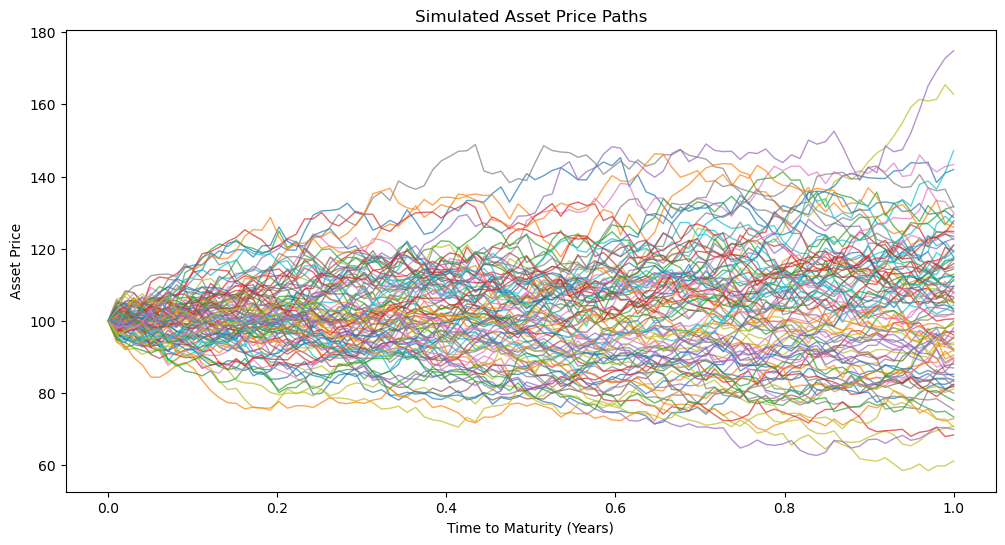

In [10]:
def plot_asset_paths(paths, T, n_time_steps, n_paths_to_plot=100):
    # Plotting a subset of the generated paths
    plt.figure(figsize=(12, 6))
    time_steps = np.linspace(0, T, n_time_steps)  # Generate time steps for the x-axis

    for i in range(n_paths_to_plot):
        plt.plot(time_steps, paths[i], lw=1, alpha=0.7)

    plt.title("Simulated Asset Price Paths")
    plt.xlabel("Time to Maturity (Years)")
    plt.ylabel("Asset Price")
    plt.show()
    
plot_asset_paths(paths, T, n_time_steps)